# 2D variability analysis for HBEC IFN experiment

In [24]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
import functools
%matplotlib inline

In [25]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [26]:
data_path = '/data_volume/ifn_hbec/'

### Get the TFs

In [27]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [28]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [29]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [30]:
adata.shape

(69958, 36588)

### Setup memento

In [31]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [32]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [33]:
memento.setup_memento(adata, q_column='q')

In [34]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


### Compute correlations with each and every TF

In [35]:
condensed_tfs = []
for tf in tfs:
    if 'STAT' in tf:
        condensed_tfs.append(tf)
    elif 'IRF' in tf:
        condensed_tfs.append(tf)
    elif 'NFKB' in tf:
        condensed_tfs.append(tf)
    elif 'JUN' in tf:
        condensed_tfs.append(tf)
    elif 'MYC' in tf:
        condensed_tfs.append(tf)
    elif 'FOS' in tf:
        condensed_tfs.append(tf)
    else:
        continue

In [36]:
cts = [['ciliated'], ['bc'], ['basal']]
tps = ['0','3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [37]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/tf_corr_deep/')

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}.csv'.format('-'.join(ct), stim, tp)
            
            if fname in done_files:
                continue          

            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin([tp]), :].copy()
            time_converter={int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            gene_list = adata_stim.var.index.tolist()
            tf_list = list(set(condensed_tfs) & set(gene_list))
            
            df_list = []
        
            for tf in tf_list:
                
                memento.compute_2d_moments(adata_stim, gene_pairs=list(itertools.product([tf], gene_list)))
                
                corr_df = memento.get_2d_moments(adata_stim, groupby='time_step')
                
                df_list.append(corr_df)
            
            pd.concat(df_list).to_csv('/data_volume/ifn_hbec/tf_corr_deep/' + fname, index=False)

### Check the expression of these TFs through time

In [52]:
mean_data_dict = {}
var_data_dict = {}
for ct in cts:
    for stim in stims:
        
        mean_df_list = []
        var_df_list = []

        for tp in tps:
            
            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin([tp]), :].copy()
            time_converter={int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            mean, var = memento.get_1d_moments(adata_stim, groupby='time_step')
            mean_df_list.append(mean.rename(columns={'time_step_1':('tp_'+str(tp))}))
            var_df_list.append(var.rename(columns={'time_step_1':('tp_'+str(tp))}))
        mean_data_dict['-'.join(ct)+'-'+stim] = functools.reduce(lambda x, y: pd.merge(x, y, on='gene', how='inner'), mean_df_list)
        var_data_dict['-'.join(ct)+'-'+stim] = functools.reduce(lambda x, y: pd.merge(x, y, on='gene', how='inner'), var_df_list)


In [ ]:
for idx, row in mean_data_dict['ciliated-gamma'].query('gene.isin(@condensed_tfs).values').iterrows():
    
    plt.figure()
    plt.plot([row['tp_' + str(t)] for t in tps])
    plt.title(row['gene'])

### Read the data

In [17]:
data_dict = {}
for ct in cts:
    for stim in stims:
        
        df_list = []

        for tp in tps:
            
            fname = '{}_{}_{}.csv'.format('-'.join(ct), stim, tp)
            
            df = pd.read_csv('/data_volume/ifn_hbec/tf_corr_deep/' + fname).rename(columns={'time_step_1':('tp_'+str(tp))})
            df_list.append(df)
            
        data_dict['-'.join(ct)+'-'+stim] = functools.reduce(lambda x, y: pd.merge(x, y, on=['gene_1', 'gene_2'], how='inner'), df_list)
        

### For a specific TF, look for gene subsets that are enriched at a particular timepoint

In [135]:
import gseapy

In [ ]:
enrich_data_dict = {}
for tf in condensed_tfs:
    for ct in cts:
        for stim in stims:

            c = '-'.join(ct)

            df = data_dict['-'.join(ct) + '-' + stim].query('gene_1 == "{}" & gene_2 != "{}"'.format(tf, tf)).copy()
            
            if df.shape[0] == 0:
                continue
                
            df_list = []

            for tp in tps:
                
                tp_genes = df.query('tp_{} > 0.35'.format(tp)).gene_2.tolist()#.sort_values('tp_' + str(tp), ascending=False).head(30).gene_2.tolist()
                
                enrich_df = gseapy.enrichr(gene_list=tp_genes, description='pathway', gene_sets='KEGG_2019_Human', outdir=None)\
                    .results.query('Term != "Ribosome"')
                
                if enrich_df['Adjusted P-value'].min() < 0.1:
                    enrich_df['tp'] = 'tp_' + str(tp)
                    df_list.append(enrich_df)
            if len(df_list) > 0:
                
                enrich_data_dict[c + '_' + stim + '_' + tf] = pd.concat(df_list)
                
                print(ct, stim, tf)
                print(enrich_data_dict[c + '_' + stim + '_' + tf].sort_values('Adjusted P-value').head(5)[['Term']])
                    
            



In [166]:
enrich_data_dict['ciliated_alpha_JUND'].sort_values('Adjusted P-value').head(5)

,Adjusted P-value,Combined Score,Gene_set,Genes,Odds Ratio,Old Adjusted P-value,Old P-value,Overlap,P-value,Term,tp
0,1.102726e-40,648.401490,KEGG_2019_Human,NDUFA13;COX7B;NDUFA11;NDUFA12;COX4I1;NDUFA10;C...,6.634233,0,0,72/133,3.580280e-43,Oxidative phosphorylation,tp_24
1,3.753705e-39,402.166164,KEGG_2019_Human,NDUFA13;COX7B;NDUFA11;NDUFA12;COX4I1;NDUFA10;C...,4.300551,0,0,90/133,2.437471e-41,Oxidative phosphorylation,tp_3
1,1.235741e-38,446.458171,KEGG_2019_Human,NDUFA13;COX7B;NDUFA11;NDUFA12;COX4I1;COX6A1;CO...,4.835801,0,0,83/133,8.024292e-41,Oxidative phosphorylation,tp_6
2,7.705118e-36,344.322558,KEGG_2019_Human,NDUFA13;COX7B;NDUFA11;NDUFA12;COX4I1;NDUFA10;U...,4.027981,0,0,90/142,7.504985e-38,Parkinson disease,tp_3
3,3.186913e-35,295.172134,KEGG_2019_Human,NDUFA13;NDUFA11;NDUFA12;NDUFA10;COX6A1;AP2M1;S...,3.523382,0,0,107/193,4.138848e-37,Huntington disease,tp_3


In [156]:
enrich_df.head(5)

,Adjusted P-value,Combined Score,Gene_set,Genes,Odds Ratio,Old Adjusted P-value,Old P-value,Overlap,P-value,Term
0,0.003210,64.825956,KEGG_2019_Human,ZCCHC7;EXOSC4;LSM6;DHX36;CNOT3;PARN;NUDT16;DCP...,5.650995,0,0,10/79,0.000010,RNA degradation
1,0.161845,22.347731,KEGG_2019_Human,ACTA2;EGR1;GABARAPL1;CCND1;RRAS;GNB1;PIK3R4;AK...,3.258603,0,0,10/137,0.001051,Apelin signaling pathway
2,0.160225,26.573442,KEGG_2019_Human,HDAC2;CCND1;CDK4;AKT1;BRAF;SOS2;TP53,4.111842,0,0,7/76,0.001561,Chronic myeloid leukemia
3,0.153216,16.577061,KEGG_2019_Human,RRAS;CCND1;ERBB3;GPC1;PDCD4;AKT1;BRAF;ITGAV;TP...,2.665245,0,0,12/201,0.001990,Proteoglycans in cancer
4,0.199818,15.130839,KEGG_2019_Human,GABARAPL1;CCND1;CDK4;MAPKAPK2;GNB1;AKT1;GNB5;T...,2.640169,0,0,11/186,0.003244,Kaposi sarcoma-associated herpesvirus infection


### For a specific TF and a timepoint, what are the genes that are most active at that time?


In [53]:
ct = ['ciliated']
stim = 'gamma'
tf = 'IRF1'
n = 50

In [54]:
# get tp genes for each timepoint
tp_genes = {}
df = data_dict['-'.join(ct) + '-' + stim].query('gene_1 == "{}" & gene_2 != "{}"'.format(tf, tf)).copy()
for tp in tps:
    
    tp_genes[tp] = df.sort_values('tp_' + tp, ascending=False).head(n).gene_2.tolist()

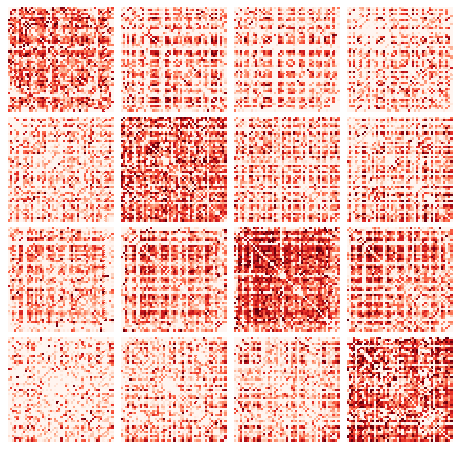

In [56]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for idx, tp in enumerate(tps[2:]):
    

    heatmaps = []
    # tp_genes = df.sort_values('tp_24', ascending=False).head(n).gene_2.tolist()
    for hm_tp in tps[2:]:
        
        adata_stim = adata.copy()[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim]) & \
            adata.obs.time.isin([hm_tp]), :].copy()
        time_converter={int(hm_tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
        memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.9)
        memento.compute_2d_moments(adata_stim, gene_pairs=list(itertools.combinations(tp_genes[tp], 2)))

        corr_df = memento.get_2d_moments(adata_stim, groupby='time_step')

        hm = np.zeros((n,n))

        hm[np.triu_indices(n, 1)] = corr_df['time_step_1'].values
        hm += hm.T
    #     hm[np.tril_indices(2*n, -1)] = corr_df['time_step_1'].values

        heatmaps.append(hm)

    for i in range(len(heatmaps)):
        plt.subplot(4, 4, (4*idx)+i+1)
        sns.heatmap(heatmaps[i], vmin=0.2, vmax=0.8, cmap='Reds', cbar=None)
        plt.xticks([]); plt.yticks([]); plt.axis('equal')